In [36]:
# --- Setup & Imports ---
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection/statistics
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, classification_report


# Optional: Boruta or RFE (install Boruta if needed)
!pip install boruta
from boruta import BorutaPy
from sklearn.feature_selection import RFE


In [37]:
# Mount Google Drive to access project files
from google.colab import drive
drive.mount('/content/drive')

# Importing dataframe after being flattened
df_binary_classification = pd.read_csv('/content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Datasets/df_preprocessed_multiclass.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
df_binary_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39336 entries, 0 to 39335
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Attack_Tag                           39336 non-null  object 
 1   severity_accept_encoding_too_long    39336 non-null  int64  
 2   severity_http_header_injection       39336 non-null  int64  
 3   severity_java_serialized_object      39336 non-null  int64  
 4   severity_java_serialized_object_alt  39336 non-null  int64  
 5   severity_rce_unix_command_evasion    39336 non-null  int64  
 6   severity_rce_unix_command_injection  39336 non-null  int64  
 7   severity_sqli_auth_bypass            39336 non-null  int64  
 8   severity_sqli_auth_bypass_4_0        39336 non-null  int64  
 9   severity_sqli_auth_bypass_4_1        39336 non-null  int64  
 10  severity_sqli_boolean_based          39336 non-null  int64  
 11  severity_sqli_boolean_based_

In [39]:
from sklearn.feature_selection import VarianceThreshold

# --- Remove constant features (variance = 0) ---
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(df_binary_classification.drop(columns=["Attack_Tag"]))
constant_columns = df_binary_classification.drop(columns=["Attack_Tag"]).columns[constant_filter.variances_ == 0].tolist()
print(f"Constant features to remove: {constant_columns}")

df = df_binary_classification.drop(columns=constant_columns)

# --- Remove quasi-constant features (variance < 0.01) ---
quasi_constant_filter = VarianceThreshold(threshold=0.01)
quasi_constant_filter.fit(df_binary_classification.drop(columns=["Attack_Tag"]))
quasi_constant_columns = df_binary_classification.drop(columns=["Attack_Tag"]).columns[quasi_constant_filter.variances_ < 0.01].tolist()
print(f"Quasi-constant features to remove: {quasi_constant_columns}")

df = df_binary_classification.drop(columns=quasi_constant_columns)


Constant features to remove: []
Quasi-constant features to remove: []


In [40]:
# --- Remove highly correlated features ---
corr_matrix = df.drop(columns=["Attack_Tag"]).corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Threshold à 0.95, garde une seule par groupe
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(f"Highly correlated features to remove: {to_drop}")

df = df.drop(columns=to_drop)

Highly correlated features to remove: ['severity_java_serialized_object_alt', 'severity_sqli_auth_bypass_4_0', 'severity_sqli_auth_bypass_4_1', 'severity_sqli_boolean_based_alt2', 'severity_sqli_injection_attack', 'severity_sqli_libinjection', 'severity_sqli_union_select', 'severity_xss_javascript_method', 'severity_xss_libinjection', 'severity_xss_script_tag', 'severity_xss_tag_handler', 'num_unique_param_names_all']


In [41]:
from sklearn.model_selection import train_test_split

# --- Définir X et y pour multi-classe ---
X = df.drop(columns=["Attack_Tag"])
y = df["Attack_Tag"].astype(str)  # Pour stratification correcte

# 1. Split TEST (15 %)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# 2. Split TRAIN / VALIDATION (15 % du total = ~17.6 % du reste)
val_relative_size = 0.15 / (1 - 0.15)  # ≈ 0.176

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_relative_size, stratify=y_temp, random_state=42
)

# Vérification des tailles et des classes
print(f"Train: {len(X_train)}\nValidation: {len(X_val)}\nTest: {len(X_test)}")
print("Train classes:\n", y_train.value_counts())
print("Validation classes:\n", y_val.value_counts())
print("Test classes:\n", y_test.value_counts())


Train: 27534
Validation: 5901
Test: 5901
Train classes:
 Attack_Tag
XSS                    5611
SQL Injection          5546
Cookie Injection       5420
Log Forging            2826
RCE                    2761
Directory Traversal    2757
LOG4J                  2613
Name: count, dtype: int64
Validation classes:
 Attack_Tag
XSS                    1203
SQL Injection          1189
Cookie Injection       1161
Log Forging             606
Directory Traversal     591
RCE                     591
LOG4J                   560
Name: count, dtype: int64
Test classes:
 Attack_Tag
XSS                    1203
SQL Injection          1189
Cookie Injection       1161
Log Forging             605
RCE                     592
Directory Traversal     591
LOG4J                   560
Name: count, dtype: int64


In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [43]:
from sklearn.preprocessing import LabelEncoder

# On encode y_train/y_val/y_test en entiers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

In [44]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

k = 15  # Ajuste si tu veux plus ou moins de features
selector_kbest = SelectKBest(mutual_info_classif, k=k)
selector_kbest.fit(X_train_scaled, y_train)

X_train_kbest = selector_kbest.transform(X_train_scaled)
X_val_kbest = selector_kbest.transform(X_val_scaled)
X_test_kbest = selector_kbest.transform(X_test_scaled)

features_kbest = X_train.columns[selector_kbest.get_support()].tolist()
print("Features sélectionnées KBest :", features_kbest)

Features sélectionnées KBest : ['severity_http_header_injection', 'severity_sqli_auth_bypass', 'severity_sqli_boolean_based', 'severity_sqli_concat_basic', 'severity_xss_html_injection', 'alert_count', 'url_length_total', 'url_param_count', 'url_path_depth', 'has_url_base64_token', 'has_cookie_base64_token', 'has_url_percent_encoding', 'max_param_length_all', 'mean_entropy_param_names_all', 'num_req_headers']


In [45]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

rf_boruta = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'   # <-- Ajoute ceci
)
boruta_selector = BorutaPy(
    rf_boruta,
    n_estimators='auto',
    perc=100,
    random_state=42,
    verbose=2
)

boruta_selector.fit(X_train_scaled, y_train.values)
boruta_mask = boruta_selector.support_

features_boruta = X_train.columns[boruta_mask].tolist()
print("Features sélectionnées Boruta :", features_boruta)

# Préparation des datasets
X_train_boruta = X_train_scaled[:, boruta_mask]
X_val_boruta = X_val_scaled[:, boruta_mask]
X_test_boruta = X_test_scaled[:, boruta_mask]


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	21
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	21
Tentative: 	0
Rejected: 	0
Features sélectionnées Boruta : ['severity_accept_encoding_too_long', 'severity_http_header_injection', 'severity_java_serialized_object', 'severity_rce_unix_command_evasion', 'severity_rce_unix_command_injection', 'severity_sqli_auth_bypass', 'severity_sqli_boolean_based', 'severity_sqli_concat_basic', 'severity_xss_angularjs_template', 'severity_xss_html_injection', 'severity_xss_libinjection_alt', 'alert_c

In [46]:
# Calcul des listes
features_union = list(sorted(set(features_kbest) | set(features_boruta)))
features_intersection = list(sorted(set(features_kbest) & set(features_boruta)))

print("Union:", features_union)
print("Intersection:", features_intersection)


Union: ['alert_count', 'has_cookie_base64_token', 'has_url_base64_token', 'has_url_percent_encoding', 'max_param_length_all', 'mean_entropy_param_names_all', 'num_req_headers', 'severity_accept_encoding_too_long', 'severity_http_header_injection', 'severity_java_serialized_object', 'severity_rce_unix_command_evasion', 'severity_rce_unix_command_injection', 'severity_sqli_auth_bypass', 'severity_sqli_boolean_based', 'severity_sqli_concat_basic', 'severity_xss_angularjs_template', 'severity_xss_html_injection', 'severity_xss_libinjection_alt', 'url_length_total', 'url_param_count', 'url_path_depth']
Intersection: ['alert_count', 'has_cookie_base64_token', 'has_url_base64_token', 'has_url_percent_encoding', 'max_param_length_all', 'mean_entropy_param_names_all', 'num_req_headers', 'severity_http_header_injection', 'severity_sqli_auth_bypass', 'severity_sqli_boolean_based', 'severity_sqli_concat_basic', 'severity_xss_html_injection', 'url_length_total', 'url_param_count', 'url_path_depth']

In [47]:
import numpy as np

# Helper pour extraire les colonnes dans le bon ordre
def get_subset(X_scaled, features_list, all_features):
    indices = [all_features.get_loc(f) for f in features_list]
    return X_scaled[:, indices]

# Pour Union
X_train_union = get_subset(X_train_scaled, features_union, X_train.columns)
X_val_union = get_subset(X_val_scaled, features_union, X_train.columns)
X_test_union = get_subset(X_test_scaled, features_union, X_train.columns)

# Pour Intersection
X_train_inter = get_subset(X_train_scaled, features_intersection, X_train.columns)
X_val_inter = get_subset(X_val_scaled, features_intersection, X_train.columns)
X_test_inter = get_subset(X_test_scaled, features_intersection, X_train.columns)


In [48]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
results_log = []
cycle = 1  # Incrémente à chaque essai

In [49]:
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

In [50]:
from sklearn.metrics import classification_report, f1_score, recall_score, roc_auc_score

results_log = []
cycle = 1  # Ou à ton numéro de cycle courant

datasets = {
    "KBest": (X_train_kbest, X_val_kbest, features_kbest),
    "Boruta": (X_train_boruta, X_val_boruta, features_boruta),
    "Union": (X_train_union, X_val_union, features_union),
    "Intersection": (X_train_inter, X_val_inter, features_intersection)
}

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=6, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, max_depth=6, random_state=42, verbosity=-1)
}

for set_name, (X_tr, X_val, feats) in datasets.items():
    for model_name, model in models.items():
        print(f"\nCycle {cycle} | Features: {set_name} | Model: {model_name}")
        model.fit(X_tr, y_train_enc)
        y_val_pred = model.predict(X_val)
        y_val_prob = model.predict_proba(X_val)

        # Multi-class metrics
        f1 = f1_score(y_val_enc, y_val_pred, average='macro')
        recall = recall_score(y_val_enc, y_val_pred, average='macro')
        # Pour roc_auc_score en multi-classe, il faut binariser les cibles
        try:
            roc_auc = roc_auc_score(
                pd.get_dummies(y_val_enc, columns=model.classes_),
                y_val_prob,
                multi_class='ovr',
                average='macro'
            )
        except Exception as e:
            roc_auc = None  # Certains modèles ne renvoient pas les bonnes proba, gère le cas

        print(classification_report(y_val_enc, y_val_pred, digits=3))
        print("ROC AUC (macro ovr):", roc_auc)

        results_log.append({
            'cycle': cycle,
            'features': set_name,
            'model': model_name,
            'params': str(model.get_params()),
            'f1_val': f1,
            'recall_val': recall,
            'roc_auc_val': roc_auc,
            'notes': ""
        })

cycle += 1

results_df = pd.DataFrame(results_log)
display(results_df)
results_df.to_csv("log_model_comparisons_multiclass.csv", index=False)



Cycle 1 | Features: KBest | Model: LogisticRegression
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1161
           1      1.000     0.998     0.999       591
           2      0.986     0.998     0.992       560
           3      1.000     1.000     1.000       606
           4      1.000     1.000     1.000       591
           5      1.000     1.000     1.000      1189
           6      0.999     0.994     0.997      1203

    accuracy                          0.998      5901
   macro avg      0.998     0.999     0.998      5901
weighted avg      0.998     0.998     0.998      5901

ROC AUC (macro ovr): 0.9999335989109331

Cycle 1 | Features: KBest | Model: RandomForest
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      1161
           1      1.000     1.000     1.000       591
           2      1.000     1.000     1.000       560
           3      1.000     1.000     1.00

,cycle,features,model,params,f1_val,recall_val,roc_auc_val,notes
0,1,KBest,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.998262,0.998672,0.999934,
1,1,KBest,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.000000,1.000000,1.000000,
2,1,KBest,XGBoost,"{'objective': 'multi:softprob', 'base_score': ...",1.000000,1.000000,1.000000,
3,1,KBest,LightGBM,"{'boosting_type': 'gbdt', 'class_weight': None...",1.000000,1.000000,1.000000,
4,1,Boruta,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.998262,0.998672,0.999922,
5,1,Boruta,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.000000,1.000000,1.000000,
6,1,Boruta,XGBoost,"{'objective': 'multi:softprob', 'base_score': ...",1.000000,1.000000,1.000000,
7,1,Boruta,LightGBM,"{'boosting_type': 'gbdt', 'class_weight': None...",1.000000,1.000000,1.000000,
8,1,Union,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.998262,0.998672,0.999922,
9,1,Union,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1.000000,1.000000,1.000000,


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Prends bien les features d'intersection
X_train_search = X_train_inter
y_train_search = y_train_enc

# Hyperparameter grid (peut élargir/réduire)
param_dist = {
    'n_estimators': np.arange(100, 601, 50),        # 100, 150, ..., 600
    'max_depth': [None] + list(np.arange(5, 25, 5)),# None, 5, 10, 15, 20
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    # class_weight=None  <-- option par défaut, tu peux l’omettre
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',  # <--- IMPORTANT : f1_macro en multi-classe
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_search, y_train_search)

print("Best parameters found:", random_search.best_params_)
print("Best F1-score (macro, CV):", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'n_estimators': np.int64(450), 'min_samples_split': 2, 'max_depth': np.int64(20)}
Best F1-score (macro, CV): 1.0


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 450, 500],
    'max_depth': [None, 6, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
)

grid = GridSearchCV(
    rf, param_grid,
    cv=3, scoring='f1_macro',
    n_jobs=-1, verbose=2
)

grid.fit(X_train_inter, y_train)
print("Best parameters:", grid.best_params_)
print("Best F1 on validation (cross-val):", grid.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 on validation (cross-val): 1.0


In [64]:
# X_trainval_inter, y_trainval : jeu complet (train + validation) sur features Intersection
import numpy as np

# Concatène train et val sur les bonnes features (Intersection)
X_trainval_inter = np.vstack([X_train_inter, X_val_inter])
y_trainval = np.concatenate([y_train_enc, y_val_enc])

from sklearn.ensemble import RandomForestClassifier

rf_final = RandomForestClassifier(  # choosed random search result for better generelization due to the lack of diversity of some attack classes
    n_estimators=450,
    max_depth=20,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_trainval_inter, y_trainval)


RandomForestClassifier(max_depth=20, n_estimators=450, n_jobs=-1,
                       random_state=42)

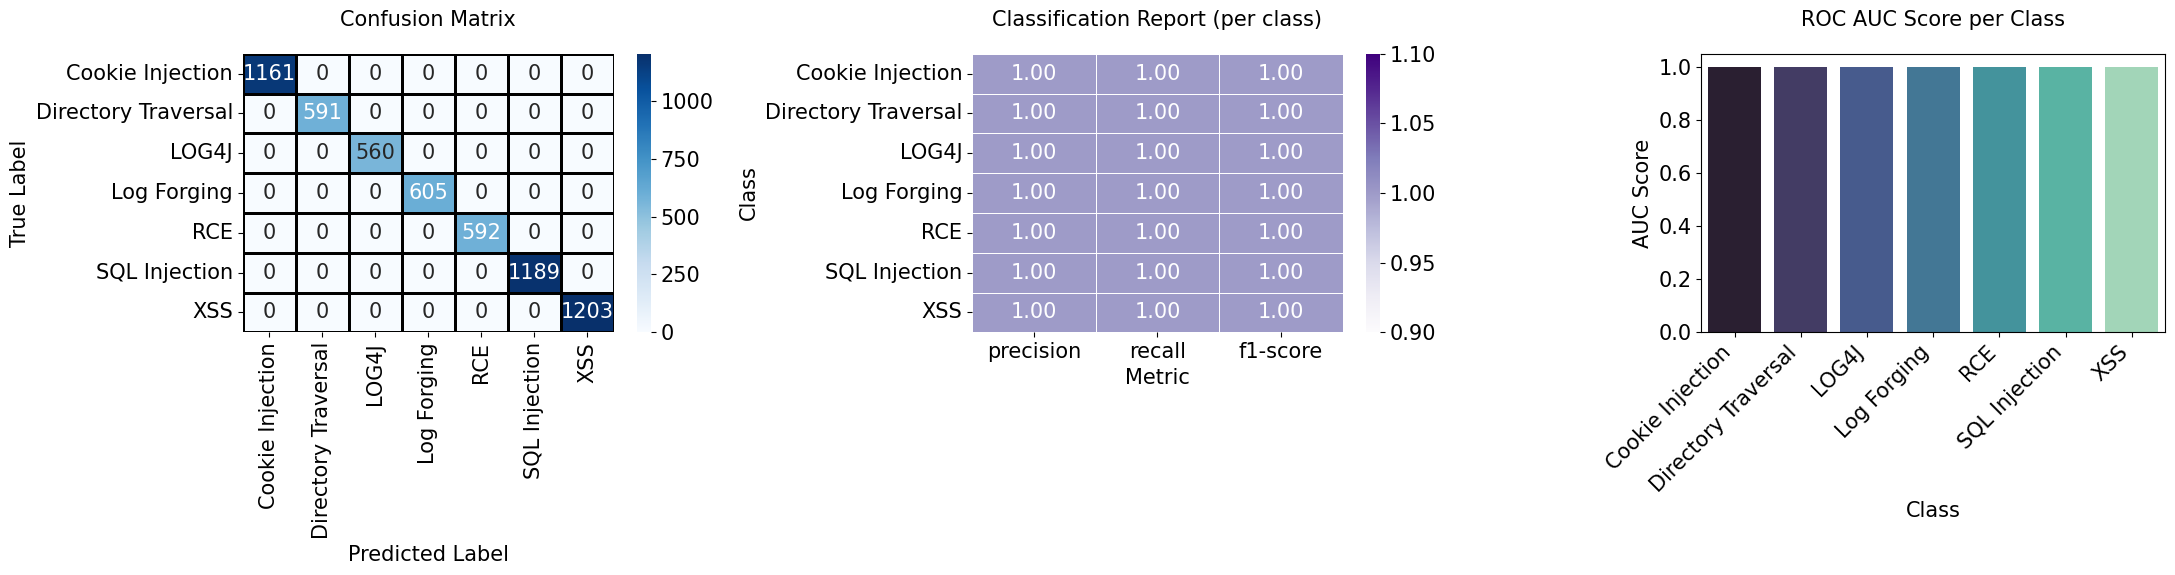

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# --- Prédictions et métriques de base ---
y_test_pred = rf_final.predict(X_test_inter)
y_test_proba = rf_final.predict_proba(X_test_inter)
cm = confusion_matrix(y_test_enc, y_test_pred)

# Classification report au format DataFrame
report = classification_report(y_test_enc, y_test_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Récupère les noms de classes (labels d'origine)
label_strings = le.classes_
labels = le.classes_

# --- Config globale du style Matplotlib ---
plt.rcParams.update({
    'axes.titlesize': 15,
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.size': 15
})

plt.figure(figsize=(22, 6))

# ------------------------------------------------------
# Subplot 1 : Matrice de confusion
# ------------------------------------------------------
plt.subplot(1, 3, 1)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=label_strings, yticklabels=label_strings,
    linewidths=1, linecolor='black', annot_kws={"size": 15}
)
plt.title("Confusion Matrix", pad=20)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# ------------------------------------------------------
# Subplot 2 : Rapport de classification
# ------------------------------------------------------
plt.subplot(1, 3, 2)
metrics_to_plot = ["precision", "recall", "f1-score"]
report_df_classes = report_df.iloc[:len(labels)]
sns.heatmap(
    report_df_classes[metrics_to_plot], annot=True, fmt=".2f", cmap="Purples", linewidths=0.5,
    xticklabels=metrics_to_plot, yticklabels=label_strings, annot_kws={"size": 15}
)
plt.title("Classification Report (per class)", pad=20)
plt.xlabel("Metric")
plt.ylabel("Class")

# ------------------------------------------------------
# Subplot 3 : AUC ROC Score par classe (robuste)
# ------------------------------------------------------
plt.subplot(1, 3, 3)
# Binarize labels for ROC/AUC (attention aux classes absentes du test set)
classes_in_test = np.unique(y_test_enc)
y_test_bin = label_binarize(y_test_enc, classes=classes_in_test)

# Calcul AUC pour chaque classe, avec gestion des classes absentes/constantes
auc_per_class = []
for i, class_idx in enumerate(classes_in_test):
    # Vérifie la présence de positifs/négatifs dans chaque colonne
    has_positives = np.any(y_test_bin[:, i] == 1)
    has_negatives = np.any(y_test_bin[:, i] == 0)
    if has_positives and has_negatives:
        try:
            auc_score = roc_auc_score(y_test_bin[:, i], y_test_proba[:, class_idx])
            auc_per_class.append(auc_score)
        except Exception as e:
            print(f"Error calculating AUC for class {labels[class_idx]} (int {class_idx}): {e}")
            auc_per_class.append(np.nan)
    else:
        print(f"Skipping AUC for class {labels[class_idx]}: Only one class present in test set.")
        auc_per_class.append(np.nan)

# DataFrame pour affichage avec seaborn
auc_df = pd.DataFrame({
    'Class': labels[classes_in_test],
    'AUC Score': auc_per_class
}).dropna(subset=['AUC Score'])

if not auc_df.empty:
    sns.barplot(x='Class', y='AUC Score', data=auc_df, palette="mako")
    plt.ylim(0, 1.05)
    plt.title("ROC AUC Score per Class", pad=20)
    plt.xlabel("Class")
    plt.ylabel("AUC Score")
    plt.xticks(rotation=45, ha='right')
else:
    plt.text(
        0.5, 0.5, "No valid AUC scores to plot",
        horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes
    )

plt.tight_layout()
plt.show()


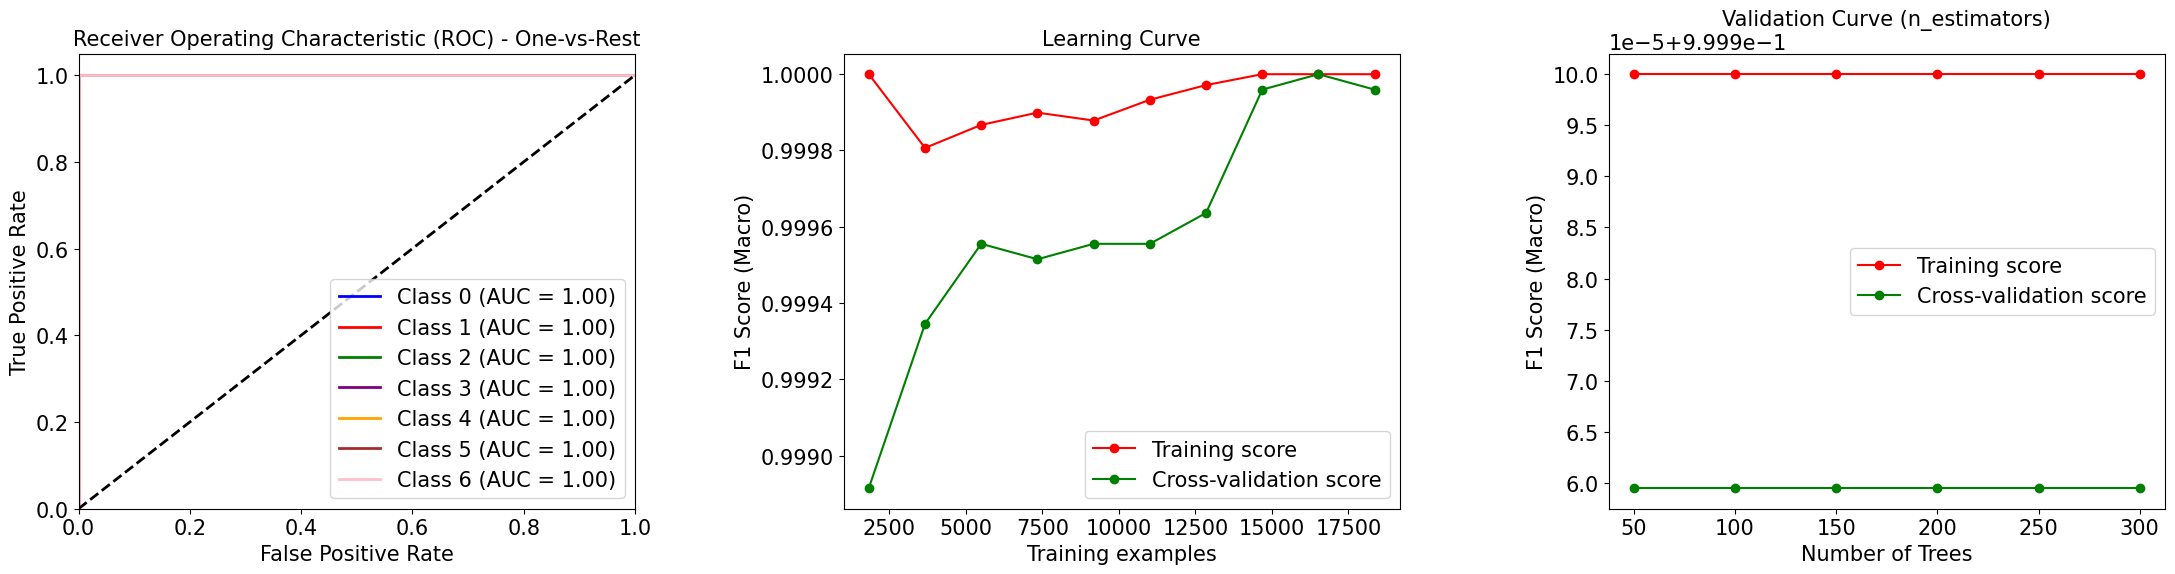

In [66]:
# --- Plot ROC Curve, Learning Curve, and Validation Curve ---
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve, validation_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize # Import label_binarize

# Configuration des tailles de police
plt.rcParams.update({
    'axes.titlesize': 15,
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15
})

plt.figure(figsize=(22, 6))

# --------------------------------------
# Subplot 1 : Courbe ROC (Multi-classe OVR)
# --------------------------------------
plt.subplot(1, 3, 1)

# Get the unique classes from the original target variable
classes = np.unique(y_test_enc) # Use the encoded test labels to get class indices

# Binarize the test set true labels
y_test_bin = label_binarize(y_test_enc, classes=classes)

colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink'] # Define colors for each class

for i, class_id in enumerate(classes):
    # Calculate ROC curve for each class (OvR)
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f'Class {class_id} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One-vs-Rest')
plt.legend(loc="lower right")

# --------------------------------------
# Subplot 2 : Courbe d'apprentissage
# --------------------------------------
plt.subplot(1, 3, 2)

# Calculation of the learning curve
# Use the original y_train for learning curve as it expects original labels or encoded
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    ),
    X_train_inter,
    y_train_enc, # Use encoded training labels
    cv=3,
    scoring='f1_macro', # Use f1_macro for multiclass
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1 Score (Macro)") # Update label to reflect macro averaging
plt.title("Learning Curve")
plt.legend()

# --------------------------------------
# Subplot 3 : Courbe de validation (n_estimators)
# --------------------------------------
plt.subplot(1, 3, 3)

# Parameter to test
param_range = [50, 100, 150, 200, 250, 300]

# Calculation of the validation curve
# Use the original y_train for validation curve
train_scores, test_scores = validation_curve(
    RandomForestClassifier(
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    ),
    X_train_inter,
    y_train_enc, # Use encoded training labels
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="f1_macro", # Use f1_macro for multiclass
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Number of Trees")
plt.ylabel("F1 Score (Macro)") # Update label to reflect macro averaging
plt.title("Validation Curve (n_estimators)")
plt.legend()

# Final adjustment
plt.tight_layout(w_pad=4)
plt.show()

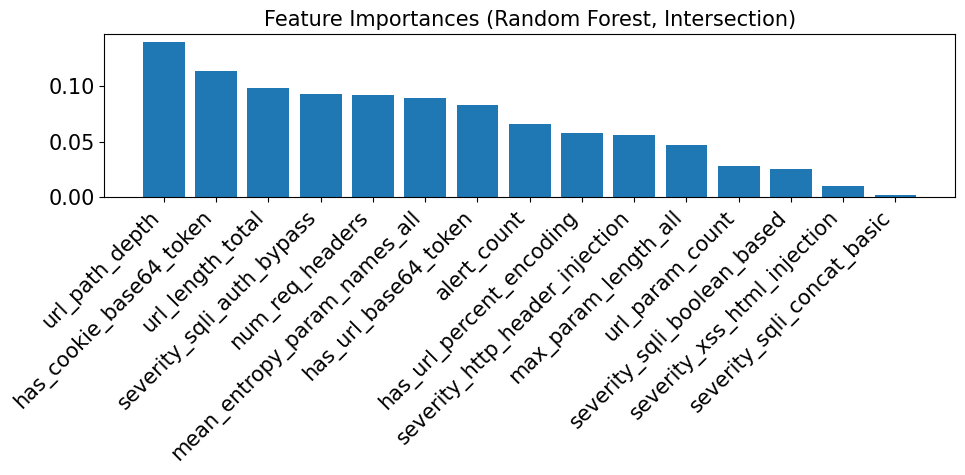

In [67]:
import matplotlib.pyplot as plt
import numpy as np

feat_importances = rf_final.feature_importances_
sorted_idx = np.argsort(feat_importances)[::-1]
plt.figure(figsize=(10, 5))
plt.bar([features_intersection[i] for i in sorted_idx], feat_importances[sorted_idx])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importances (Random Forest, Intersection)')
plt.tight_layout()
plt.show()


In [68]:
import joblib
joblib.dump(rf_final, "/content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Model_Exported/RF_MULTICLASS.joblib")

['/content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Model_Exported/RF_MULTICLASS.joblib']